In [1]:
import numpy as np

%matplotlib notebook
import matplotlib.pyplot as plt

import astropy.units as u
from astropy.timeseries import BoxLeastSquares


In [2]:
data = np.genfromtxt('XO2N_PDCSAP_flattened_biweight.dat')
# You can use "panda" as well, this is the simplest way since we are not dealing with complex databases

time = data[:,0]
flux = data[:,1]
flux_err = data[:,2]


In [3]:
# BLS
model_bls = BoxLeastSquares(time, flux, dy=flux_err)
periodogram = model_bls.autopower(0.1, minimum_period=0.3, maximum_period=8, minimum_n_transit=3,  objective="snr")
# pay attention to the maximum period

<IPython.core.display.Javascript object>


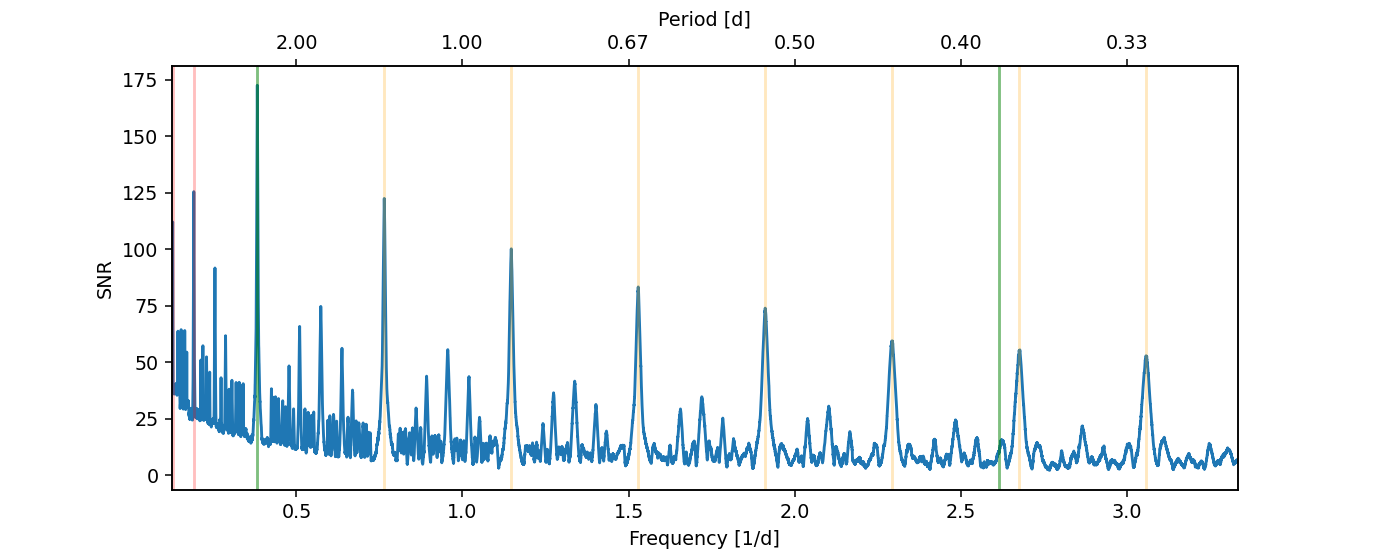

In [14]:
# REMEMBER: periodograms must always go on frequency scale

from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import FuncFormatter

fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(111)

ax1.plot(1./periodogram.period, periodogram.power)

ax1.set_xlabel("Frequency [1/d]")
ax1.set_ylabel("SNR")


#Magic trick that I learnt in the past and now I forgot how it works
plt.setp(ax1.get_xticklabels(), visible=False)

ax2 = ax1.twiny()
ax1.get_shared_x_axes().join(ax1,ax2)

# This must be put here, otherwise it will not work!
ax1.set_xlim(np.amin(1./periodogram.period), np.amax(1./periodogram.period))


f = lambda q: 1./q
finv = lambda x: 1./x
ax2.xaxis.set_major_formatter(FuncFormatter(lambda k,pos: f"{finv(k):.2f}"))
ax2.set_xlabel('Period [d]')

# period from Exoplanet archive
known_period = 2.61585922 # Gaudi+2017

# multiple of the period
for ii in range(2,5):
    ax1.axvline(1./(ii*known_period), c='red', alpha=0.25)

# fraction of periods
for ii in range(2,10):
    ax1.axvline(1./(known_period/ii), c='orange', alpha=0.25)

ax1.axvline(1./known_period, c='green', alpha=0.5)
plt.show()

<IPython.core.display.Javascript object>


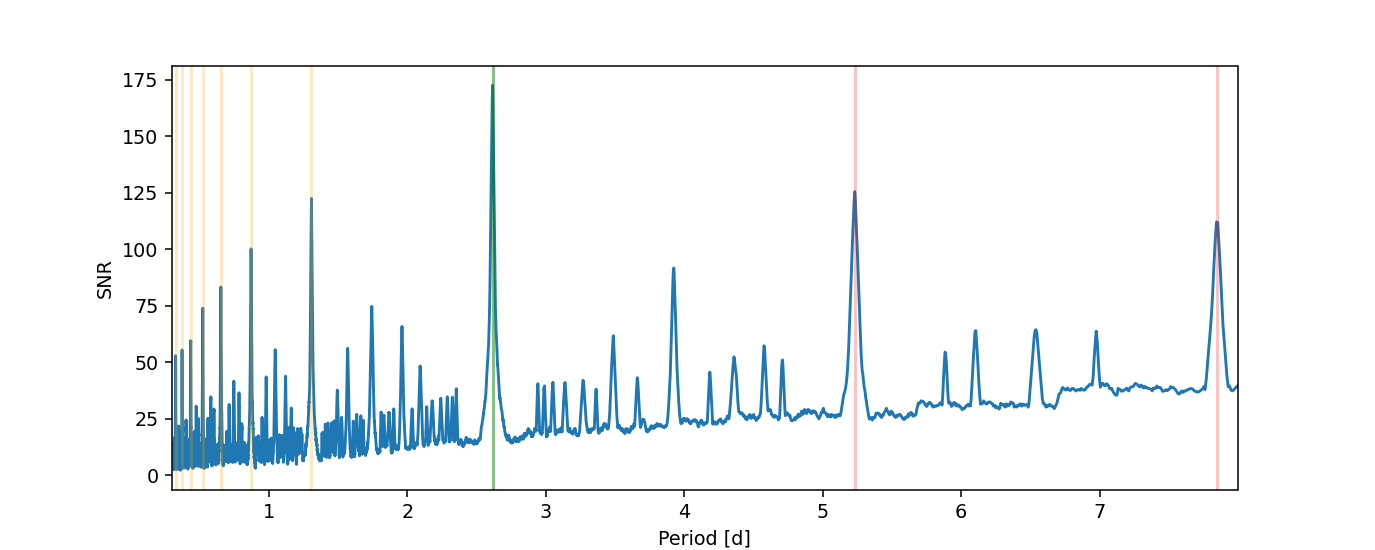

In [16]:
# Ok let's make in Period because it makes sense in this case

plt.figure(figsize=(10,4))

plt.plot(periodogram.period, periodogram.power)

plt.xlabel("Period [d]")
plt.ylabel("SNR")

# This must be put here, otherwise it will not work!
plt.xlim(np.amin(periodogram.period), np.amax(periodogram.period))

# period from Exoplanet archive
# multiple of the period
for ii in range(2,5):
    plt.axvline(ii*known_period, c='red', alpha=0.25)

# fraction of period
for ii in range(2,10):
    plt.axvline(known_period/ii, c='orange', alpha=0.25)

plt.axvline(known_period, c='green', alpha=0.5)
plt.show()

## Choose the most prominent peak


Period with max Power: P= 2.6160 days, Tc = 2458843.2187. 
Depth and duration: 0.0116 %, T14 = 0.1000. 
Alternative Epoch: 2458866.7626686315


<IPython.core.display.Javascript object>


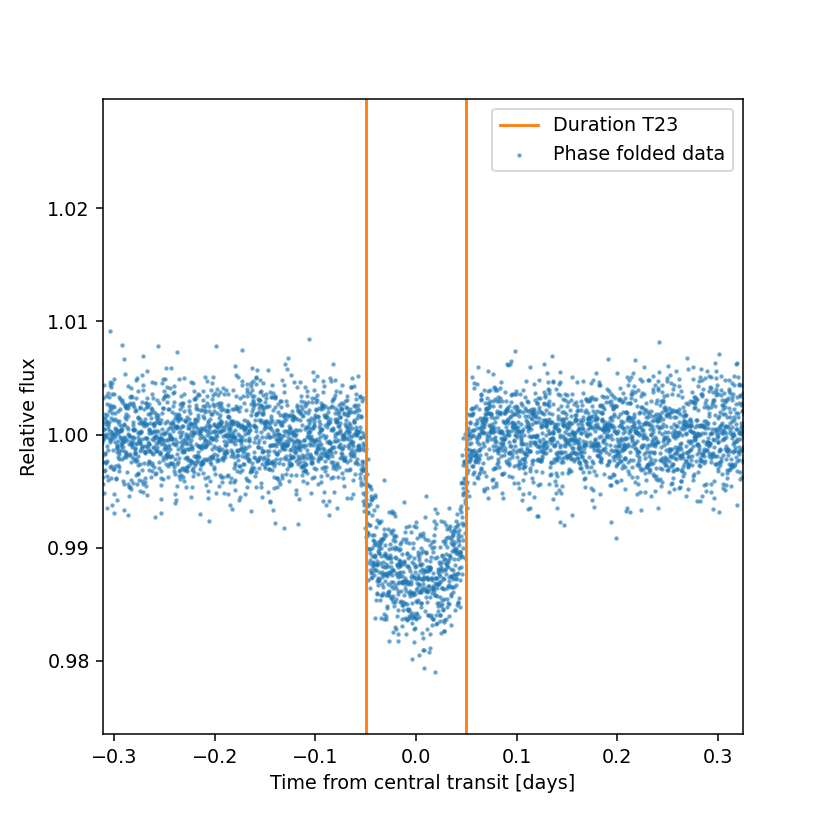

In [17]:
max_power = np.argmax(periodogram.power)
period_bls = periodogram.period[max_power]
epoch_bls = periodogram.transit_time[max_power]
depth_bls = (periodogram.depth[max_power])
duration_bls = periodogram.duration[max_power]

print('Period with max Power: P= {:.4f} days, Tc = {:.4f}. '
      .format(period_bls, epoch_bls))
print('Depth and duration: {:.4f} %, T14 = {:.4f}. '
      .format(depth_bls, duration_bls))

# Compute stats:
stats = model_bls.compute_stats(periodogram.period[max_power],
                            periodogram.duration[max_power],
                            periodogram.transit_time[max_power])

print('Alternative Epoch: {}'.format(stats['transit_times'][-1]))
epoch_bls = stats['transit_times'][0]

# phase fold plot:
phase = (time - epoch_bls) % period_bls / period_bls
phase[np.where(phase>0.5)] -= 1 


## plot the phase fold
plt.figure(figsize=(6,6))
plt.scatter(phase*period_bls, flux, c='C0', s=2, alpha=0.5, label='Phase folded data')
plt.xlim(-period_bls/2, period_bls/2.)

plt.axvline(-duration_bls/2, c='C1', label='Duration T23')
plt.axvline(duration_bls/2, c='C1')

plt.xlabel("Time from central transit [days]")
plt.ylabel("Relative flux")
plt.legend()
plt.show()

In [18]:
# TLS 
from transitleastsquares import transitleastsquares
model_tls = transitleastsquares(time, flux)
results = model_tls.power()

/home/malavolta/anaconda3/lib/python3.8/site-packages/transitleastsquares/transit.py:157: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  lc_arr = numpy.array(lc_arr)
  0%|          | 0/2321 periods | 00:00<?

Transit Least Squares TLS 1.0.25 (04 June 2020)
Creating model cache for 38 durations
Searching 15727 data points, 2321 periods from 0.601 to 12.858 days
Using all 12 CPU threads


100%|██████████| 2321/2321 periods | 00:17<00:00


In [19]:
print('Period', format(results.period, '.5f'), 'd')
print(len(results.transit_times), 'transit times in time series:', \
        ['{0:0.5f}'.format(i) for i in results.transit_times])
print('Normalized flux at the center of transit', format(results.depth, '.5f'))
print('Best duration (days)', format(results.duration, '.5f'))
print('Signal detection efficiency (SDE):', results.SDE)


Period 2.61570 d
10 transit times in time series: ['2458843.21982', '2458845.83553', '2458848.45123', '2458851.06693', '2458853.68263', '2458856.29833', '2458858.91404', '2458861.52974', '2458864.14544', '2458866.76114']
Normalized flux at the center of transit 0.98649
Best duration (days) 0.09132
Signal detection efficiency (SDE): 19.070611044653976


<IPython.core.display.Javascript object>


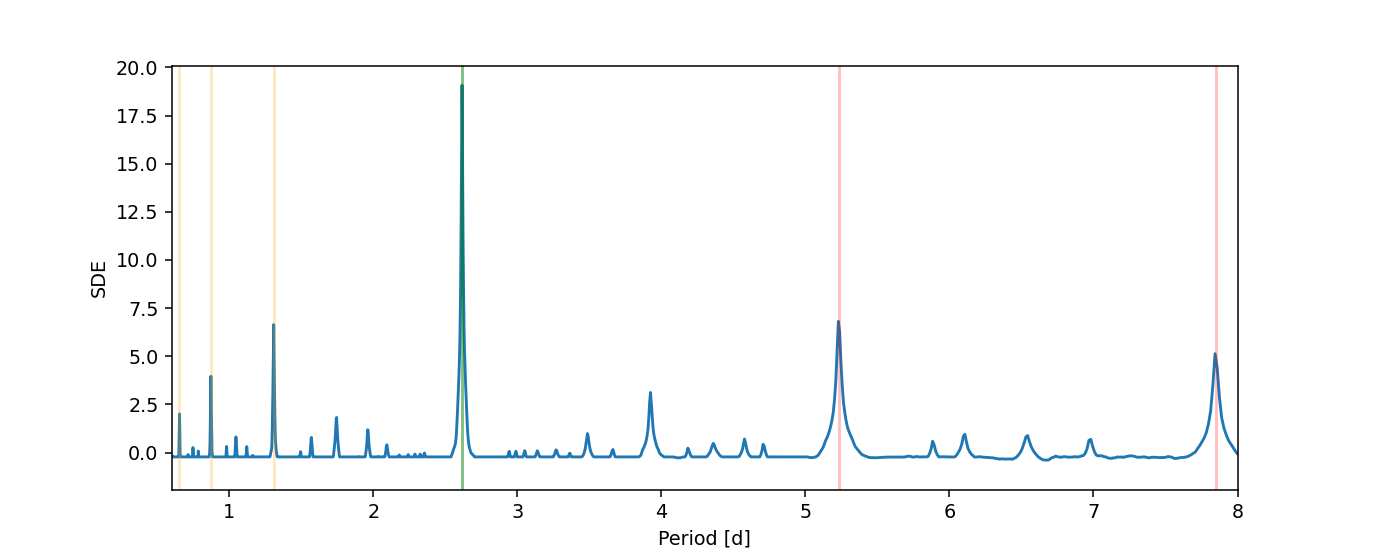

In [20]:
plt.figure(figsize=(10,4))

plt.plot(results.periods, results.power)
# Note: here is periods 

plt.xlabel("Period [d]")
plt.ylabel(r'SDE')

# This must be put here, otherwise it will not work!
plt.xlim(np.amin(results.periods), 8.)

# period from Exoplanet archive
# period from Exoplanet archive
# multiple of the period
for ii in range(2,5):
    plt.axvline(ii*known_period, c='red', alpha=0.25)

# fraction of period
for ii in range(2,10):
    plt.axvline(known_period/ii, c='orange', alpha=0.25)

plt.axvline(known_period, c='green', alpha=0.5)

plt.show()

<IPython.core.display.Javascript object>


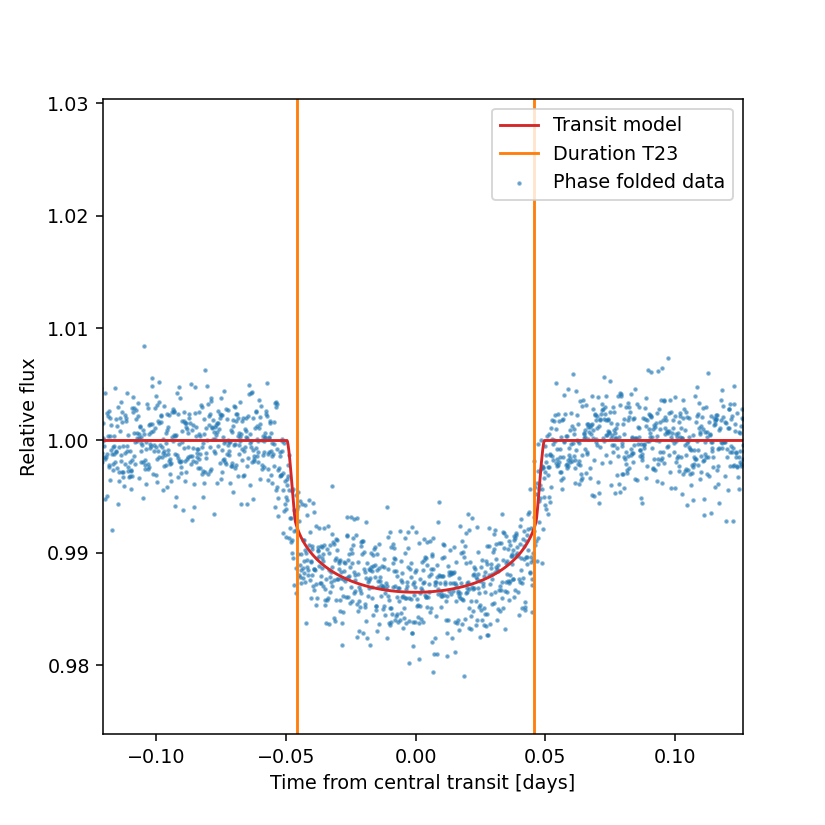

In [21]:
plt.figure(figsize=(6,6))
plt.scatter((results.folded_phase-0.5)*results.period, results.folded_y, c='C0', s=2, alpha=0.5, label='Phase folded data')
plt.plot((results.model_folded_phase-0.5)*results.period, results.model_folded_model, color='C3', label='Transit model')


plt.xlim(-results.period/2, results.period/2.)

plt.axvline(-results.duration/2, c='C1', label='Duration T23')
plt.axvline(results.duration/2, c='C1')
plt.legend()

plt.xlabel("Time from central transit [days]")
plt.ylabel("Relative flux");